In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100110323_hourly_meteostat.csv')
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
df.drop('READ_DATE_day', axis=1, inplace=True)
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP,temp,dwpt,rhum,wdir,wspd,pres,coco
READ_DATE,,,,,,,,
2019-01-01 00:00:00,2.402650,26.1,25.2,95.0,140.0,5.4,1010.0,7.0
2019-01-01 01:00:00,2.408348,27.7,24.7,84.0,321.0,5.5,1009.8,7.0
2019-01-01 02:00:00,2.406840,28.7,24.7,79.0,329.0,7.4,1009.7,7.0
2019-01-01 03:00:00,2.256511,25.4,24.9,97.0,323.0,0.0,1010.1,7.0
2019-01-01 04:00:00,2.065598,29.5,25.0,77.0,327.0,11.1,1008.9,8.0
...,...,...,...,...,...,...,...,...
2024-05-31 19:00:00,65.205495,28.2,23.1,74.0,150.0,9.4,1011.6,2.0
2024-05-31 20:00:00,65.520523,28.2,23.1,74.0,150.0,9.4,1011.6,2.0
2024-05-31 21:00:00,66.389436,28.2,23.1,74.0,150.0,9.4,1011.6,2.0


In [37]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':]

In [38]:
scaler = StandardScaler()

In [39]:
# scaling data train
train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
train_scaled



,KWH_EXP,temp,dwpt,rhum,wdir,wspd,pres,coco
READ_DATE,,,,,,,,
2019-01-01 00:00:00,-0.921600,-0.466364,1.185728,1.343937,-0.420074,-0.741796,0.370252,0.708480
2019-01-01 01:00:00,-0.920917,0.074062,0.935136,0.514419,1.720327,-0.720198,0.268182,0.708480
2019-01-01 02:00:00,-0.921098,0.411829,0.935136,0.137365,1.814930,-0.309831,0.217147,0.708480
2019-01-01 03:00:00,-0.939135,-0.702801,1.035373,1.494759,1.743978,-1.908102,0.421287,0.708480
2019-01-01 04:00:00,-0.962042,0.682042,1.085491,-0.013457,1.791279,0.489305,-0.191132,0.927251
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,-0.891599,-0.702801,0.584308,1.117705,1.377390,0.899672,-0.956655,1.146022
2022-12-31 20:00:00,-0.870325,-0.669024,0.534190,1.042294,1.436517,0.899672,-1.007690,1.146022
2022-12-31 21:00:00,-0.870764,-0.229928,0.634426,0.589829,1.590247,2.519541,-0.650446,0.927251


In [40]:
# scaling data test
test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
test_scaled

,KWH_EXP,temp,dwpt,rhum,wdir,wspd,pres,coco
READ_DATE,,,,,,,,
2023-01-01 00:00:00,-0.857399,-0.061044,0.885018,0.589829,1.590247,3.297079,0.166112,0.708480
2023-01-01 01:00:00,-0.865644,0.006509,0.885018,0.514419,1.519295,1.288441,-0.191132,0.708480
2023-01-01 02:00:00,-0.872474,0.276722,0.935136,0.288186,1.578422,1.698808,-0.242167,0.708480
2023-01-01 03:00:00,-0.869078,0.513159,1.085491,0.137365,1.708501,3.297079,-0.191132,0.708480
2023-01-01 04:00:00,-0.871847,0.546936,1.035373,0.061954,1.637549,2.497943,-0.497341,0.708480
...,...,...,...,...,...,...,...,...
2024-05-31 19:00:00,6.613860,0.242946,0.133243,-0.239689,-0.301820,0.122135,1.186810,-0.385377
2024-05-31 20:00:00,6.651659,0.242946,0.133243,-0.239689,-0.301820,0.122135,1.186810,-0.385377
2024-05-31 21:00:00,6.755916,0.242946,0.133243,-0.239689,-0.301820,0.122135,1.186810,-0.385377


In [41]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [42]:
# jika datanya diambil setiap 1 jam maka timestep nya 24

time_steps = 24
# reshape ke bentuk 3D array
X_train, y_train = create_dataset(train_scaled, train_scaled['KWH_EXP'], time_steps)
X_test, y_test = create_dataset(test_scaled, test_scaled['KWH_EXP'], time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(35040, 24, 8) (35040,)
(12384, 24, 8) (12384,)


In [43]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 24, 256)             │         140,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 304,769 (1.16 MB)

 Trainable params: 304,769 (1.16 MB)

 Non-trainable params: 0 (0.00 B)


SPLITTING DATA RATIO :

* Train data : tahun 2019-2022 akhir
* Test data : tahun 2023-ujung data
* Validation data : diambil 10% dari training data

In [45]:
#  callback
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
# learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.3901 - val_loss: 0.0528 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1128 - val_loss: 0.1056 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1119 - val_loss: 0.0366 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0798 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0754 - val_loss: 0.0337 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0733 - val_loss: 0.0338 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0658 - val_loss: 0.0303 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0613 - val_loss: 0.0275 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0585 - val_loss: 0.0274 - learning_rate: 6.703

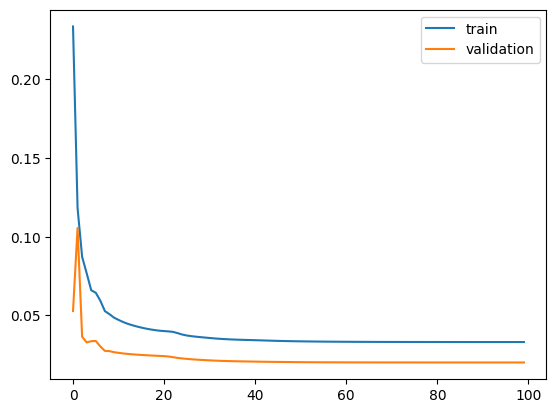

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot   (history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [47]:
# predict

y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)


387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


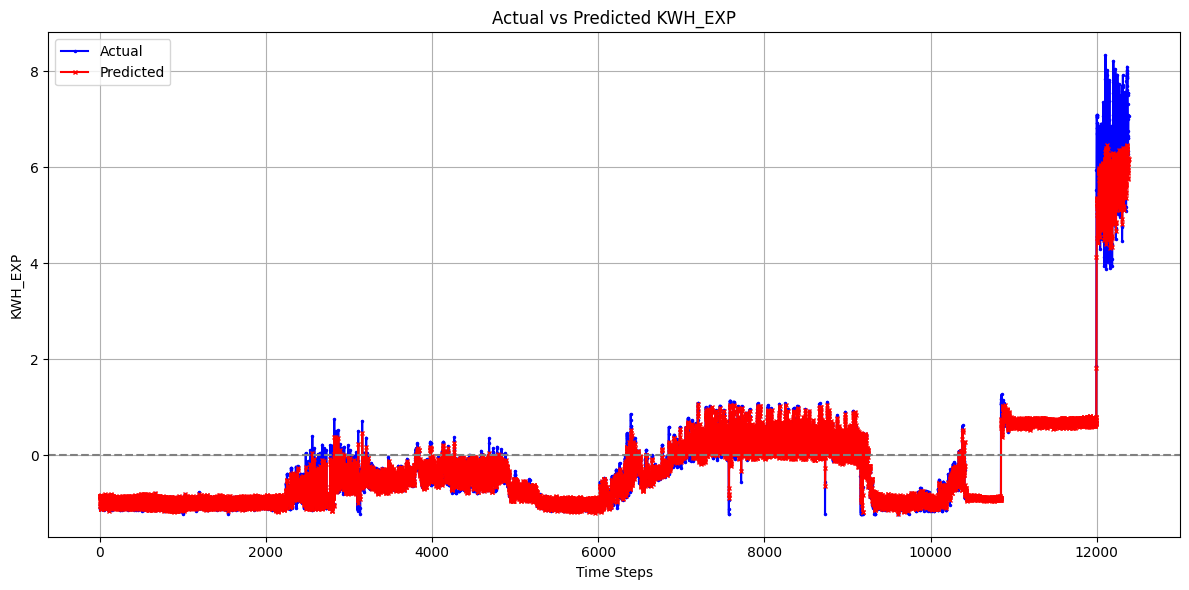

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Garis referensi
plt.title('Actual vs Predicted KWH_EXP')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [49]:
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.040616787336729666
MAE: 0.08887661673568557
R2: 0.9775365842689896
MAPE: 0.7498028124256046


# ATTENTION

In [50]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = LSTM(units=128, return_sequences=True)(inputs)
x = AttentionLayer()(x)
x = LSTM(units=64, return_sequences=False)(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 24, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 24, 128)             │          70,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_2 (AttentionLayer)   │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,617 (467.25 KB)

 Trainable params: 119,617 (467.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.4975 - val_loss: 0.1057 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2501 - val_loss: 0.0714 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1767 - val_loss: 0.0689 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1631 - val_loss: 0.0601 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1476 - val_loss: 0.0635 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1457 - val_loss: 0.0550 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1267 - val_loss: 0.0548 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1203 - val_loss: 0.0533 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1139 - val_loss: 0.0524 - learning_rate: 6.703

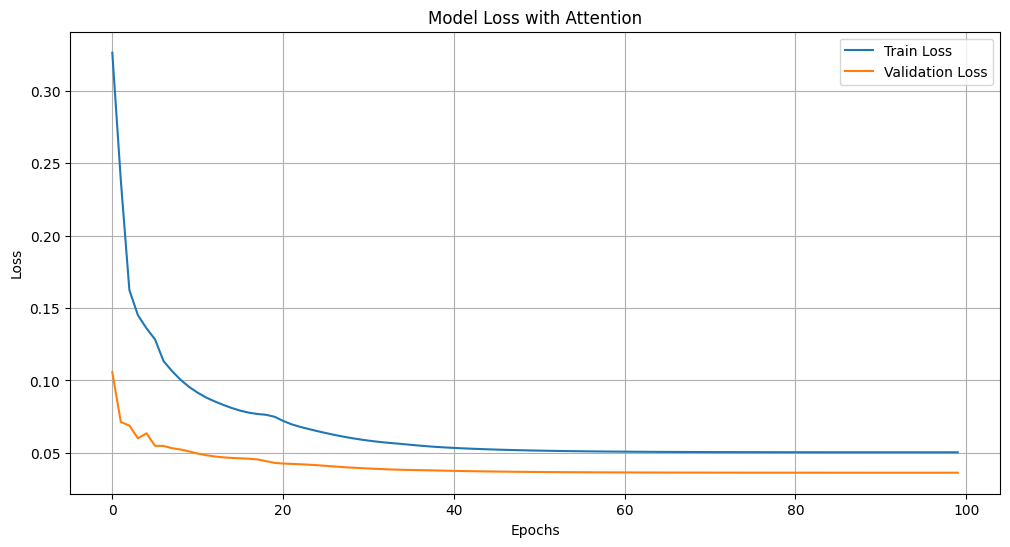

387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [51]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

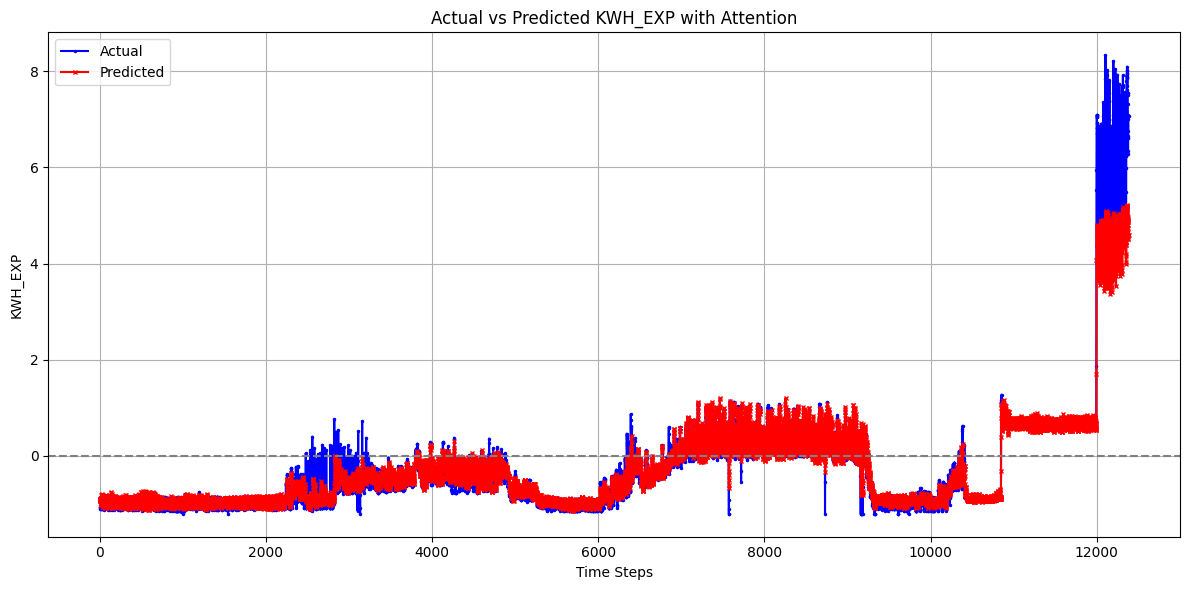

In [52]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [53]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.14328640348980964
MAE: 0.1484408398130712
R²: 0.9207543909490294
MAPE: 0.9613528631634821


BILSTM ATTENTION

In [54]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = Bidirectional(LSTM(units=128, return_sequences=True))(inputs)
x = AttentionLayer()(x)
x = Bidirectional(LSTM(units=64, return_sequences=False))(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 24, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 24, 256)             │         140,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_3 (AttentionLayer)   │ (None, 24, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 304,769 (1.16 MB)

 Trainable params: 304,769 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.3849 - val_loss: 0.1449 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1986 - val_loss: 0.1025 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1574 - val_loss: 0.0600 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1257 - val_loss: 0.0514 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1063 - val_loss: 0.0534 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0907 - val_loss: 0.0412 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0798 - val_loss: 0.0376 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0742 - val_loss: 0.0364 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0725 - val_loss: 0.0344 - learning_rate: 6.703

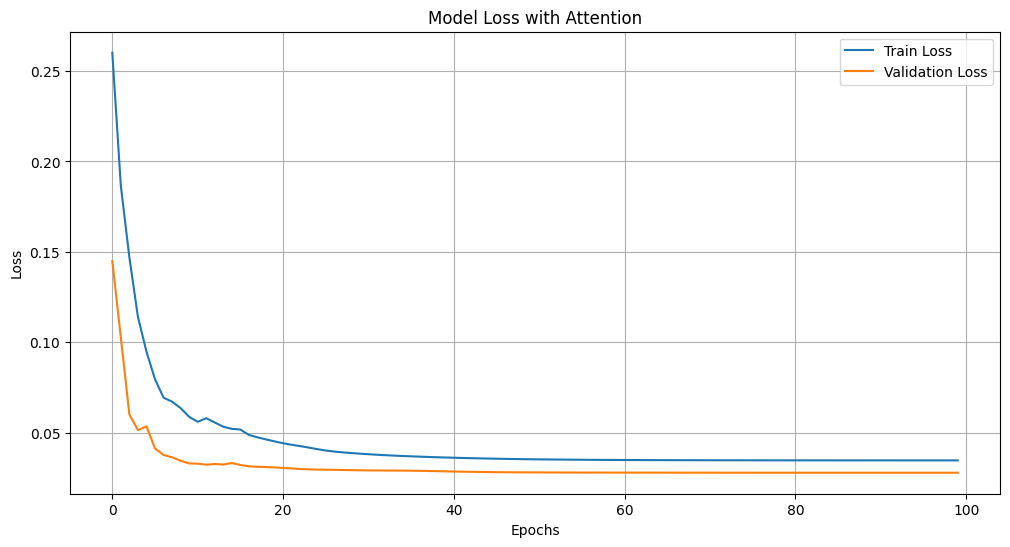

387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [55]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

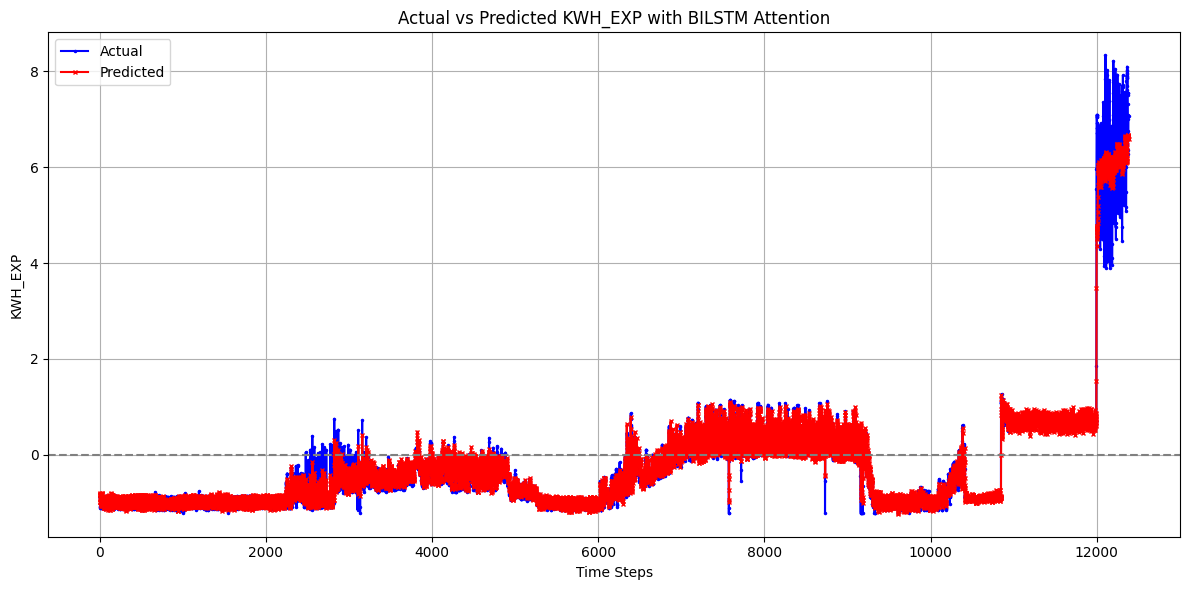

In [56]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with BILSTM Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [57]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.053496910844174274
MAE: 0.1090358427574318
R²: 0.9704131363553028
MAPE: 0.9111017733393879


# LSTM

In [58]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=1))

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 24, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 24, 256)             │         140,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_3 (AttentionLayer)   │ (None, 24, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 304,769 (1.16 MB)

 Trainable params: 304,769 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0666 - val_loss: 0.0634 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0863 - val_loss: 0.0453 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0649 - val_loss: 0.0388 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0558 - val_loss: 0.0393 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0578 - val_loss: 0.0378 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0574 - val_loss: 0.0340 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0515 - val_loss: 0.0301 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0471 - val_loss: 0.0302 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0473 - val_loss: 0.0315 - learning_rate: 6.703

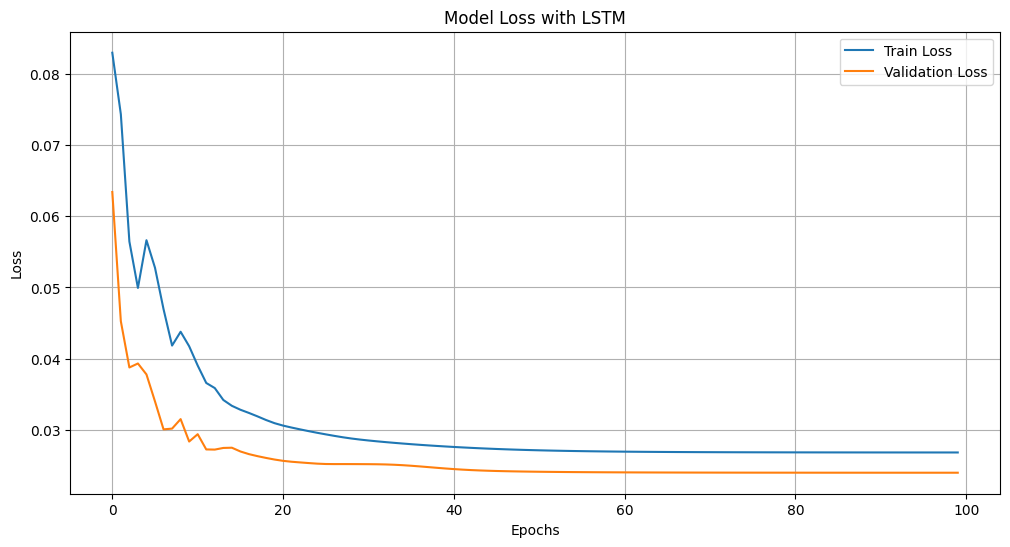

387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [59]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

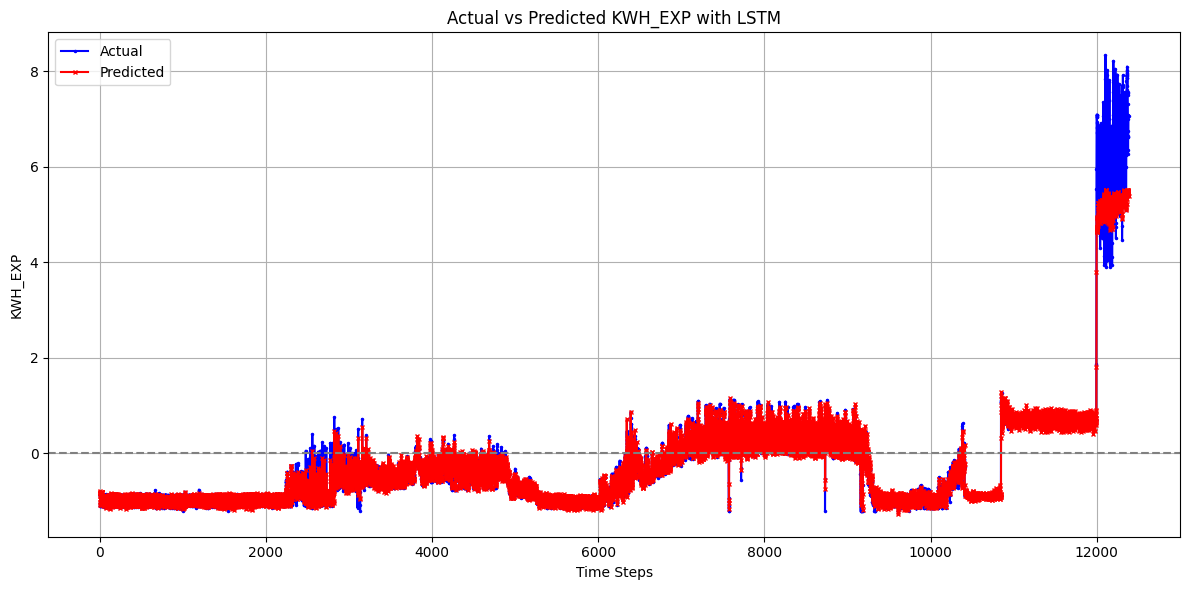

In [60]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with LSTM')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [61]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.08750791584972069
MAE: 0.11250659993206859
R²: 0.9516030975766282
MAPE: 0.7194103966649581
